In [290]:
import quandl
import os
quandl.ApiConfig.api_key = os.environ["QUANDL_API_KEY"]

In [ ]:
data = quandl.get_table('WIKI/PRICES', 
                        qopts = { 'columns': ['ticker', 'date', 'close'] }, 
                        date = { 'gte': '2016-01-01', 'lte': '2016-12-31' })



In [316]:
years = np.arange(2014, 2021)
years

array([2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [ ]:
filename = f"../wiki_data/quandl_close_price_{year}.zip"
    quandl.export_table("WIKI/PRICES", 
                        qopts = { 'columns': ['ticker', 'date', 'close'] },
                        date = { 'gte': f'{year}-01-01', 'lte': f'{year}-12-31' },
                       filename = filename)

In [318]:
for year in years:
    filename = f"../wiki_data/quandl_close_price_{year}.zip"
    quandl.export_table("WIKI/PRICES", 
                        qopts = { 'columns': ['ticker', 'date', 'close'] },
                        date = { 'gte': f'{year}-01-01', 'lte': f'{year}-12-31' },
                       filename = filename)

In [319]:
from glob import glob, iglob
import zipfile
import re
root = "/Users/matzhaugen/projects/concord-fastapi/wiki_data"
for my_zipfile in iglob(f"{root}/*.zip"):
    print(my_zipfile)
    m = re.search('\d+', my_zipfile)
    year = m.group(0)
    with zipfile.ZipFile(my_zipfile, "r") as zf:
        for csv_file in zf.namelist():
            zf.extract(csv_file, path=f"{root}")
            os.rename(f"{root}/{csv_file}", f"{root}/{year}.csv")

/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_1996.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_1997.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2008.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2020.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2009.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2019.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2018.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2015.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2001.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2000.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2014.zip
/Users/matzhaugen/projects/concord-fastapi/wiki_data/quandl_close_price_2002.zip
/Users/matzhaugen/projects/c

In [339]:
# Merge all years to one csv
df = pd.DataFrame(columns=["ticker", "date", "close"])
for csv_file in glob(f"{root}/*.csv"):
    print(csv_file)
    df = pd.concat([df, pd.read_csv(csv_file)])

/Users/matzhaugen/projects/concord-fastapi/wiki_data/1996.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/1997.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2008.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2020.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2009.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2019.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2018.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2001.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2015.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2014.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2000.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2016.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2002.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2003.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2017.csv
/Users/matzhaugen/projects/concord-fastapi/wiki_data/2013.csv
/Users/m

In [348]:
df.index = pd.to_datetime(df.date)
df = df.sort_index()
df.to_csv("../historical_data/history.csv", columns=["ticker", "date", "close"], index=False)

In [ ]:
# Import libraries
from pymaf import maf
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

def scale(arr):
    return np.apply_along_axis(lambda x: (x - np.mean(x)) / np.std(x), arr=arr, axis=0)

# Import data
tickers = ["F", "AAPL", "GOOG", "AMD", "ACN"]
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2015, 1, 27)
prices = web.DataReader(tickers, 'yahoo', start_date, end_date)

open = prices['Open'].dropna().values
n_samples = len(open)
n_tickers = len(tickers)
print("number of samples: ", n_samples)
# Calculate MAFs and normalize MAF factors

In [263]:
returns = np.diff(open, axis=0) / open[:-1, :]

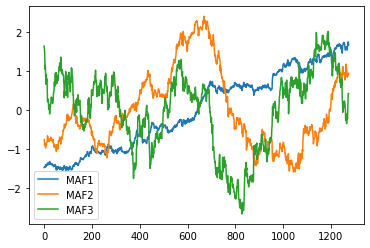

In [266]:
mafs, w = maf(open)

mafs = scale(mafs)

# Plot
labels = ['MAF' + s for s in ['1','2','3'] ]
for y_arr, label in zip(mafs[:, :3].T, labels):
	plt.plot(y_arr, label=label)
plt.legend()
plt.show()

In [286]:
weights = []
steps = 5
min_observations = 800
n_samples = len(prices["Open"])
start_idx = np.arange(0, n_samples-min_observations + 1, steps)
end_idx = np.arange(min_observations, n_samples + 1, steps)
print(start_idx, end_idx)

weights = np.zeros((len(start_idx), n_tickers, n_tickers))
for i, (start, end) in enumerate(zip(start_idx, end_idx)):
    chunk = prices["Open"].values[start:end, :]
    maf_output = maf(chunk)
    flip = np.sum(maf_output[0][:, :] * np.arange(len(chunk))[:, np.newaxis], axis=0) > 0
    flip = flip.astype(int) * 2 - 1
    weights[i,:,:] = maf_output[1] * flip[np.newaxis, :]


n_samples = len(open)
n_tickers = len(tickers)
windowed_weights = np.zeros((n_samples, n_tickers, n_tickers))
last_end = 0
for i, (start, end) in enumerate(zip(start_idx, end_idx)):
    windowed_weights[last_end:end, :, :] = weights[i, :, :]
    last_end = end
if end < n_samples:
    windowed_weights[end:, :, :] = windowed_weights[(end - 1), :, :]

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355
 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445
 450 455 460 465 470 475] [ 800  805  810  815  820  825  830  835  840  845  850  855  860  865
  870  875  880  885  890  895  900  905  910  915  920  925  930  935
  940  945  950  955  960  965  970  975  980  985  990  995 1000 1005
 1010 1015 1020 1025 1030 1035 1040 1045 1050 1055 1060 1065 1070 1075
 1080 1085 1090 1095 1100 1105 1110 1115 1120 1125 1130 1135 1140 1145
 1150 1155 1160 1165 1170 1175 1180 1185 1190 1195 1200 1205 1210 1215
 1220 1225 1230 1235 1240 1245 1250 1255 1260 1265 1270 1275]


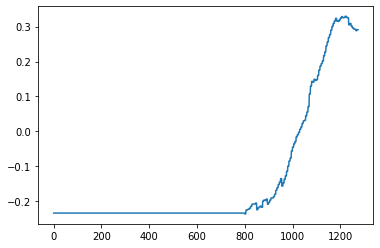

In [287]:
plt.plot(windowed_weights[:,0,0])

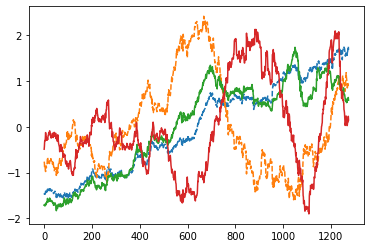

In [288]:
windowed_mafs = windowed_weights[:, :, 0:2] * open[:, :, np.newaxis]
windowed_mafs = scale(np.sum(windowed_mafs, axis=1))
windowed_mafs.shape
plt.plot(mafs[:, :2], '--')
plt.plot(windowed_mafs)

In [281]:
windowed_mafs = windowed_weights * open[:, :, np.newaxis]
windowed_mafs = np.sum(windowed_mafs, axis=1)
windowed_mafs.shape

(1275, 5)

In [282]:
times = prices["Open"].index[min_observations::steps]
maf1 = np.array(weights)[:, :, 0]
tickers = ["F", "AAPL", "GOOG", "AMD", "ACN"]


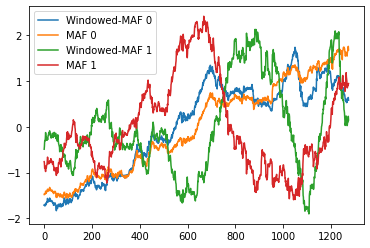

In [283]:
n_mafs = 2
for i, (y_windowed, y_maf, label) in enumerate(zip(
    scale(windowed_mafs[:, 0:n_mafs]).T, 
    first_mafs[:, 0:n_mafs].T, 
    tickers)):
    plt.plot(y_windowed, label=f"Windowed-MAF {i}")
    plt.plot(y_maf, label=f"MAF {i}")
plt.legend()
plt.show()

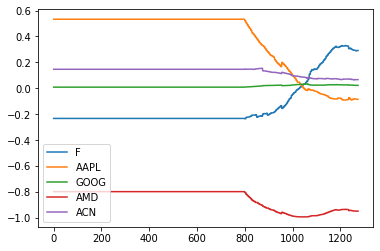

In [285]:
maf1_windowed = windowed_weights[:, :, 0]
for y_arr, label in zip(maf1_windowed.T, tickers):
    plt.plot(y_arr, label=label)
plt.legend()
plt.show()

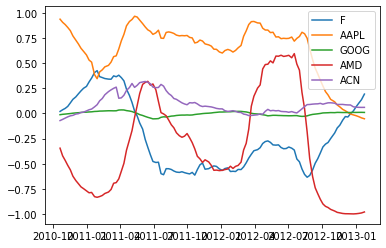

In [146]:
maf1 = maf1 * flip[:, None]
for y_arr, label in zip(maf1.T, tickers):
    plt.plot(times, y_arr, label=label)
plt.legend()
plt.show()

In [104]:
windowed_weights = np.zeros(prices["Open"].shape)

In [101]:
open_prices = prices["Open"].values
open_prices.shape

(771, 5)

In [102]:
maf1

(115, 5)